
# Float vertical position control, ensta prototype


---

## Equations of motion

For basics about float dynamics go [here](https://github.com/apatlpo/cognac/blob/master/instrum/float_dynamics_basics.ipynb)

We assume now that the float has the ability to control its volume between two bounds $V+v_{min}$ and $V+v_{max}$
with a precision $dv$.

---

## Control

We control the float vertical position with sliding modes, see [this notebook](https://github.com/apatlpo/cognac/blob/master/instrum/zcontrol_realistic.ipynb) for more details about control.


In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import numpy as np
from scipy.interpolate import interp1d
import time
from copy import deepcopy

from matplotlib import animation, rc
from IPython.display import HTML

from float_lib import *

WOA water profile at lon=-50, lat=40


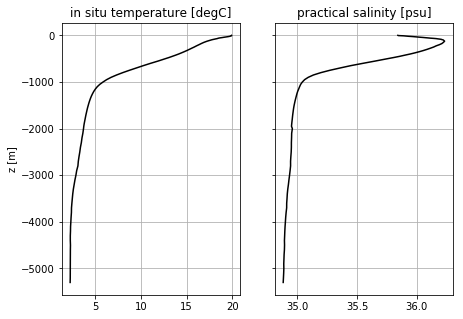

In [2]:
# select a water profile
w = waterp(lon=-50.,lat=40.)
print(w)
#w.show_on_map()

--- 
## Instantiate the float object

In [3]:
# Init now active control of the vertical position

#
z=np.arange(-100.,0.,1.)
rho_w, p, temp = w.get_rho(z), w.get_p(z), w.get_temp(z)

#
f = autonomous_float(model='ENSTA')

# compute compressibility
gamma=compute_gamma(f.r,.005,material='polycarbonat')
print('Float compressibility = %e /dbar \n' %(gamma))
f.gamma=gamma

# adjust mass to be at equilibrium at -25m
iz = np.argmin(np.abs(z+25))
f.adjust_m(p[iz],temp[iz],rho_w[iz])

# set vmax such that the float has an extra buoyancy at the surface equal
# to a cylinder ot 2cm radius and height of 10cm (antenna casing)
iz = np.argmin(np.abs(z+0.))
vmax = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz]) + .1*np.pi*.02**2
# use d_max to prescribe piston max course
dmax = .07

#
f.init_piston(d_max=dmax,vol_max=vmax,vol=vmax)
print(f)

# compute bounds on motions
fmax, fmin, afmax, wmax = f.compute_bounds(w,-500.)

Float compressibility = 9.300000e-05 /dbar 

131.8 g were added to the float in order to be at equilibrium at 25 dbar 

Piston max displacement set from max volume
Float parameters: 
  L     = 0.50 m      - float length
  r     = 0.06 m      - float radius
  m     = 5.79 kg     - float mass
  V     = 5.65e+03 cm^3   - float volume
  rho_cte     = 1.02e+09 kg.cm^3   - float constant density
  gamma = 9.30e-05 /dbar  - mechanical compressibility
  alpha = 0.00e+00 /degC  - thermal compressibility
  temp0 = 0.00e+00  degC  - reference temperature
  a = 1.00e+00  (no dimension)  - float added mass
  c0 = 0.00e+00  (no dimension)  - float drag parameter 0
  c1 = 1.00e+00  (no dimension)  - float drag parameter 1
Piston parameters and state: 
  r     = 25.00 mm        - piston radius
  phi   = 0.00 rad       - present angle of rotation
  d     = 0.00 mm        - present piston displacement
  vol   = 114.46 cm^3      - present volume addition
  lead  = 1.75 cm        - screw lead
  tick_per_t

In [4]:
rho_eq = rho_w[iz]
temp_eq = temp[iz]
p_eq=20
f.piston_update_vol(f.piston.vol_max)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))
f.piston_update_vol(f.piston.vol_min)
print(rho_eq - f.rho(p=p_eq, temp=temp_eq))

20.597707653301427
-3.9710755106480065


In [5]:
# adjust piston to be at equilibrium 20m
iz = np.argmin(np.abs(z+20.))
vmax = f.set_piston4equilibrium(p[iz],temp[iz],rho_w[iz])
print('z equilibrium = %.1fm' %(f.z4equilibrium(w) ) ) # check

# compute float vertical displacement associated with 1mm piston displacement
f.piston.update_d(f.piston.d+.001)
f.piston_update_vol()
print('z equilibrium after 1 mm piston displacement = %.1fm' %(f.z4equilibrium(w) ) )

Piston reset : vol=-2.2e+00 cm^3  
z equilibrium = -20.0m
z equilibrium after 1 mm piston displacement = -24.4m


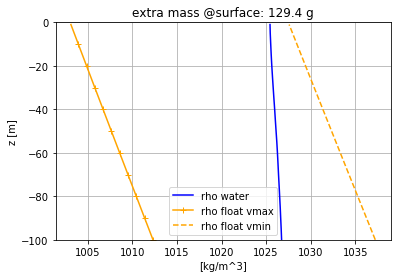

In [6]:
# show densities
plot_float_density(z, f, w)

---

## From the surface down to a target level

In [7]:
# we start by constructing a trajectory that can be followed by the float
z_target = descent(3600, -25., f, w)

Acceleration and velocity bounds (zmin=-500m,zmax=0m):
fmax/m=2.2e-01 m^2/s, fmin/m= -4.5e-01 m^2/s, wmax= 386.3 cm/s
For accelerations, equivalent speed reached in 1min:
  fmax 1.3e+03 cm/s, fmin/m= -2.7e+03 cm/s


In [8]:
# time step float with control
#control = {'tau': 10.,'dz_nochattering': 1., 'mode': 'sliding', 'd3y_ctrl': afmax/f.m/1.}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 0.02}
#control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
control = {'tau': 2.0, 'dz_nochattering': 1., 'mode': 'kalman_feedback', 'nu': 0.03*2./np.pi, 'delta': 1.}
#
f.time_step(w,T=300., dt_step=.1, dt_store=1., z=-10., w=0., v=f.piston.vol_max,
             usepiston=True, z_target=z_target, ctrl=control, verbose=1)

v 0.00011446191940347092
 ctrl: tau = 2.0
 ctrl: dz_nochattering = 1.0
 ctrl: mode = kalman_feedback
 ctrl: Lv = 0.5
 ctrl: dt_ctrl = 0.1
 ctrl: nu = 0.01909859317102744
 ctrl: delta = 1.0
Start time stepping for 5 min ...
x0 initial [-0.00000000e+00  1.00000000e+01  1.14461919e-04  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[0.  0. ]
 [0.5 0. ]
 [0.  0.5]
 [0.  0. ]]
ytilde [ 4.24448527e-06 -9.64648350e-12]
x0 iteration [-9.68326231e-02  1.00000021e+01  1.14461915e-04  0.00000000e+00]
x_hat [-9.68326231e-02  1.00000021e+01  1.14461915e-04  0.00000000e+00]
u 0
z -10.0
v 0.00011446191940347092
gamma [[1.37002983e-04 9.46235118e-12 0.00000000e+00 0.00000000e+00]
 [9.46235118e-12 1.50000000e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.0, 10.0, 0.00011446191940347092, 0.0]
[-w, -z, v, self.Ve] [-0.010546463055468655, 10.0, 0.00010885093416856319, 1.5794

gamma [[1.01029306e-04 1.13021955e-11 0.00000000e+00 0.00000000e+00]
 [1.13021955e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.22175000879029205, 8.325663304535041, 2.5125993977468564e-05, -2.023586700158472e-05]
[-w, -z, v, self.Ve] [-0.22214078870742918, 8.303488303656012, 2.5125993977468564e-05, -2.032987044970853e-05]
[-w, -z, v, self.Ve] [-0.22252380427038468, 8.28127422478527, 2.5125993977468564e-05, -2.0421965798741952e-05]
[-w, -z, v, self.Ve] [-0.22289921458769438, 8.25902184435823, 2.5125993977468564e-05, -2.0512184931341988e-05]
[-w, -z, v, self.Ve] [-0.22326717608171504, 8.23673192289946, 2.5125993977468564e-05, -2.0600559520471654e-05]
[-w, -z, v, self.Ve] [-0.22362784250776063, 8.214405205291289, 2.5125993977468564e-05, -2.0687121013687546e-05]
[-w, -z, v, self.Ve] [-0.22398136497448243, 8.192042421040513, 2.512599397

[-w, -z, v, self.Ve] [-0.24052734527584155, 5.682862903985318, 2.5125993977468564e-05, -2.4223877317322646e-05]
[-w, -z, v, self.Ve] [-0.24059241784951474, 5.658810169457734, 2.5125993977468564e-05, -2.423141948039674e-05]
[-w, -z, v, self.Ve] [-0.2406569107535772, 5.6347509276727825, 2.5125993977468564e-05, -2.423879516743025e-05]
[-w, -z, v, self.Ve] [-0.2407208377808061, 5.6106852365974245, 2.5125993977468564e-05, -2.4246008278942905e-05]
[-w, -z, v, self.Ve] [-0.24078421240079673, 5.586613152819344, 2.5125993977468564e-05, -2.4253062626391116e-05]
[-w, -z, v, self.Ve] [-0.24084704776735097, 5.562534731579264, 2.5125993977468564e-05, -2.425996193409564e-05]
[-w, -z, v, self.Ve] [-0.24090935672570327, 5.538450026802529, 2.5125993977468564e-05, -2.4266709841159127e-05]
x0 initial [-1.79003217e-01  5.61314049e+00  1.28284526e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31979465e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.0

[-w, -z, v, self.Ve] [-0.24689147440641718, 2.5368383249499082, 2.5125993977468564e-05, -2.4551852979114e-05]
[-w, -z, v, self.Ve] [-0.24693527189330416, 2.5121491775092664, 2.5125993977468564e-05, -2.455265279468692e-05]
[-w, -z, v, self.Ve] [-0.24697904881666688, 2.487455650319936, 2.5125993977468564e-05, -2.4553446615599992e-05]
[-w, -z, v, self.Ve] [-0.24702280568035787, 2.462757745438269, 2.5125993977468564e-05, -2.455423459007794e-05]
[-w, -z, v, self.Ve] [-0.24706654297596461, 2.4380554648702333, 2.5125993977468564e-05, -2.4555016862772617e-05]
[-w, -z, v, self.Ve] [-0.24711026118310625, 2.4133488105726366, 2.5125993977468564e-05, -2.4555793574836362e-05]
[-w, -z, v, self.Ve] [-0.24715396076972254, 2.388637784454326, 2.5125993977468564e-05, -2.4556564864013155e-05]
[-w, -z, v, self.Ve] [-0.24719764219235615, 2.363922388377354, 2.5125993977468564e-05, -2.4557330864718177e-05]
x0 initial [-1.78955800e-01  2.44889016e+00  1.27956100e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.3

[-w, -z, v, self.Ve] [-0.2522735613038361, -0.0, 2.5125993977468564e-05, -2.4902429824108207e-05]
[-w, -z, v, self.Ve] [-0.25229203333105665, -0.0, 2.5125993977468564e-05, -2.490806954479521e-05]
[-w, -z, v, self.Ve] [-0.25231003934080726, -0.0, 2.5125993977468564e-05, -2.4913567403343074e-05]
x0 initial [-1.79157835e-01 -2.75837483e-01  1.27551990e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31971931e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.75844114e-01 1.23708073e-05]
x0 iteration [-1.79164795e-01 -2.84513089e-01  1.27546569e-05  0.00000000e+00]
x_hat [-1.79164795e-01 -2.84513089e-01  1.27546569e-05  0.00000000e+00]
u -6.185945727055777e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998224e-04 1.13091535e-11 0.00000000e+00 0.00000000e+00]
 [1.13091535e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00

[-w, -z, v, self.Ve] [-0.2529822818420708, -0.0, 2.5125993977468564e-05, -2.5119121866322932e-05]
[-w, -z, v, self.Ve] [-0.2529828496096363, -0.0, 2.5125993977468564e-05, -2.511929571835865e-05]
[-w, -z, v, self.Ve] [-0.2529834030136723, -0.0, 2.5125993977468564e-05, -2.5119465172636197e-05]
[-w, -z, v, self.Ve] [-0.25298394241752, -0.0, 2.5125993977468564e-05, -2.5119630340381953e-05]
[-w, -z, v, self.Ve] [-0.252984468175331, -0.0, 2.5125993977468564e-05, -2.5119791330010157e-05]
[-w, -z, v, self.Ve] [-0.2529849806322998, -0.0, 2.5125993977468564e-05, -2.5119948247193956e-05]
[-w, -z, v, self.Ve] [-0.25298548012489014, -0.0, 2.5125993977468564e-05, -2.5120101194934685e-05]
x0 initial [-1.79191178e-01 -2.89947142e-01  1.27535452e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968621e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89941453e-01 1.23724511e-05]
x0 iteration [-1.79191510e-01 -2.89943394e-01

[-w, -z, v, self.Ve] [-0.25300396170996964, -0.0, 2.5125993977468564e-05, -2.512576059480653e-05]
[-w, -z, v, self.Ve] [-0.2530039809917892, -0.0, 2.5125993977468564e-05, -2.512576649948011e-05]
[-w, -z, v, self.Ve] [-0.2530039997857711, -0.0, 2.5125993977468564e-05, -2.5125772254763552e-05]
[-w, -z, v, self.Ve] [-0.25300401810425777, -0.0, 2.5125993977468564e-05, -2.5125777864436462e-05]
[-w, -z, v, self.Ve] [-0.25300403595927934, -0.0, 2.5125993977468564e-05, -2.5125783332182818e-05]
x0 initial [-1.79192796e-01 -2.89936666e-01  1.27534865e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968462e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89917694e-01 1.23724936e-05]
x0 iteration [-1.79192807e-01 -2.89949220e-01  1.27534793e-05  0.00000000e+00]
x_hat [-1.79192807e-01 -2.89949220e-01  1.27534793e-05  0.00000000e+00]
u -6.186253921114516e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090

[-w, -z, v, self.Ve] [-0.25300469923734836, -0.0, 2.5125993977468564e-05, -2.5125986448228343e-05]
x0 initial [-1.79192879e-01 -2.89936354e-01  1.27534856e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89935887e-01 1.23725006e-05]
x0 iteration [-1.79192877e-01 -2.89937748e-01  1.27534803e-05  0.00000000e+00]
x_hat [-1.79192877e-01 -2.89937748e-01  1.27534803e-05  0.00000000e+00]
u -6.186255676534799e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.2530046998594059, -0.0, 2.5125993977468564e-05, -2.5125986638721655e-05]
[-w, -z, v, self.Ve] [-0.25300470046572504, -0.0, 2.5125993977468

[-w, -z, v, self.Ve] [-0.25300472292251214, -0.0, 2.5125993977468564e-05, -2.5125993701360777e-05]
[-w, -z, v, self.Ve] [-0.25300472294532383, -0.0, 2.5125993977468564e-05, -2.5125993708346434e-05]
x0 initial [-1.79192890e-01 -2.89939881e-01  1.27534875e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89948477e-01 1.23725036e-05]
x0 iteration [-1.79192889e-01 -2.89933505e-01  1.27534825e-05  0.00000000e+00]
x_hat [-1.79192889e-01 -2.89933505e-01  1.27534825e-05  0.00000000e+00]
u -6.186256820564473e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.2530047229675584, -0.0, 2.5125993977468

[-w, -z, v, self.Ve] [-0.2530047237835569, -0.0, 2.5125993977468564e-05, -2.5125993965039413e-05]
x0 initial [-1.79192886e-01 -2.89933836e-01  1.27534824e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89943067e-01 1.23725191e-05]
x0 iteration [-1.79192888e-01 -2.89930799e-01  1.27534875e-05  0.00000000e+00]
x_hat [-1.79192888e-01 -2.89930799e-01  1.27534875e-05  0.00000000e+00]
u -6.186254433209319e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.2530047237845838, -0.0, 2.5125993977468564e-05, -2.5125993965353882e-05]
[-w, -z, v, self.Ve] [-0.2530047237855847, -0.0, 2.512599397746856

[-w, -z, v, self.Ve] [-0.25300472382276606, -0.0, 2.5125993977468564e-05, -2.512599397704648e-05]
[-w, -z, v, self.Ve] [-0.2530047238228009, -0.0, 2.5125993977468564e-05, -2.512599397705717e-05]
[-w, -z, v, self.Ve] [-0.2530047238228349, -0.0, 2.5125993977468564e-05, -2.5125993977067572e-05]
[-w, -z, v, self.Ve] [-0.25300472382286804, -0.0, 2.5125993977468564e-05, -2.5125993977077716e-05]
[-w, -z, v, self.Ve] [-0.25300472382290035, -0.0, 2.5125993977468564e-05, -2.5125993977087603e-05]
[-w, -z, v, self.Ve] [-0.2530047238229318, -0.0, 2.5125993977468564e-05, -2.5125993977097245e-05]
[-w, -z, v, self.Ve] [-0.2530047238229625, -0.0, 2.5125993977468564e-05, -2.5125993977106637e-05]
[-w, -z, v, self.Ve] [-0.25300472382299244, -0.0, 2.5125993977468564e-05, -2.5125993977115806e-05]
[-w, -z, v, self.Ve] [-0.2530047238230216, -0.0, 2.5125993977468564e-05, -2.5125993977124733e-05]
x0 initial [-1.79192879e-01 -2.89924004e-01  1.27534834e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06

[-w, -z, v, self.Ve] [-0.2530047238240988, -0.0, 2.5125993977468564e-05, -2.512599397745461e-05]
[-w, -z, v, self.Ve] [-0.25300472382409994, -0.0, 2.5125993977468564e-05, -2.5125993977454954e-05]
[-w, -z, v, self.Ve] [-0.25300472382410105, -0.0, 2.5125993977468564e-05, -2.5125993977455313e-05]
[-w, -z, v, self.Ve] [-0.25300472382410216, -0.0, 2.5125993977468564e-05, -2.512599397745564e-05]
[-w, -z, v, self.Ve] [-0.2530047238241032, -0.0, 2.5125993977468564e-05, -2.5125993977455974e-05]
[-w, -z, v, self.Ve] [-0.25300472382410427, -0.0, 2.5125993977468564e-05, -2.5125993977456286e-05]
x0 initial [-1.79192885e-01 -2.89943266e-01  1.27534819e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89936550e-01 1.23725155e-05]
x0 iteration [-1.79192885e-01 -2.89944256e-01  1.27534853e-05  0.00000000e+00]
x_hat [-1.79192885e-01 -2.89944256e-01  1.27534853e-05  0.0

[-w, -z, v, self.Ve] [-0.2530047238241427, -0.0, 2.5125993977468564e-05, -2.512599397746805e-05]
[-w, -z, v, self.Ve] [-0.25300472382414274, -0.0, 2.5125993977468564e-05, -2.5125993977468066e-05]
[-w, -z, v, self.Ve] [-0.2530047238241428, -0.0, 2.5125993977468564e-05, -2.5125993977468083e-05]
[-w, -z, v, self.Ve] [-0.25300472382414285, -0.0, 2.5125993977468564e-05, -2.51259939774681e-05]
[-w, -z, v, self.Ve] [-0.2530047238241429, -0.0, 2.5125993977468564e-05, -2.5125993977468117e-05]
x0 initial [-1.79192871e-01 -2.89946075e-01  1.27534803e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89965601e-01 1.23725120e-05]
x0 iteration [-1.79192870e-01 -2.89929096e-01  1.27534831e-05  0.00000000e+00]
x_hat [-1.79192870e-01 -2.89929096e-01  1.27534831e-05  0.00000000e+00]
u -6.186253265718453e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.1309080

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192876e-01 -2.89941816e-01  1.27534795e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192883e-01 -2.89926723e-01  1.27534843e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89945313e-01 1.23725097e-05]
x0 iteration [-1.79192883e-01 -2.89922295e

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192879e-01 -2.89922873e-01  1.27534867e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89916463e-01 1.23725116e-05]
x0 iteration [-1.79192883e-01 -2.89936272e-01  1.27534865e-05  0.00000000e+00]
x_hat [-1.79192883e-01 -2.89936272e-01  1.27534865e-05  0.00000000e+00]
u -6.186256027302437e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.512599397746856

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192891e-01 -2.89930673e-01  1.27534859e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968452e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89902716e-01 1.23725068e-05]
x0 iteration [-1.79192890e-01 -2.89952580e-01  1.27534832e-05  0.00000000e+00]
x_hat [-1.79192890e-01 -2.89952580e-01  1.27534832e-05  0.000

x0 iteration [-1.79192875e-01 -2.89952076e-01  1.27534858e-05  0.00000000e+00]
x_hat [-1.79192875e-01 -2.89952076e-01  1.27534858e-05  0.00000000e+00]
u -6.186252101557292e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192870e-01 -2.89937358e-01  1.27534787e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89939668e-01 1.23725068e-05]
x0 iteration [-1.79192867e-01 -2.89936406e-01  1.27534797e-05  0.00000000e+00]
x_hat [-1.79192867e-01 -2.89936406e-01  1.27534797e-05  0.00000000e+00]
u -6.1862524521500115e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192872e-01 -2.89936092e-01  1.27534858e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89921759e-01 1.23725054e-05]
x0 iteration [-1.79192874e-01 -2.89946211e-01  1.27534829e-05  0.00000000e+00]
x_hat [-1.79192874e-01 -2.89946211e-01  1.27534829e-05  0.000

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192877e-01 -2.89932220e-01  1.27534891e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89928603e-01 1.23724976e-05]
x0 iteration [-1.79192877e-01 -2.89938115e

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192877e-01 -2.89934338e-01  1.27534841e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968454e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89938553e-01 1.23725044e-05]
x0 iteration [-1.79192875e-01 -2.89934082e

[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
x0 initial [-1.79192889e-01 -2.89936107e-01  1.27534818e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968452e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89937139e-01 1.23725134e-05]
x0 iteration [-1.79192887e-01 -2.89936737e-01  1.27534843e-05  0.00000000e+00]
x_hat [-1.79192887e-01 -2.89936737e-01  1.27534843e-05  0.00000000e+00]
u -6.186254276857864e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.130908

u -6.186255319890948e-06
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]
[-w, -z, v, self.Ve] [-0.2530047238241433, -0.0, 2.5125993977468564e-05, -2.5125993977468253e-05]

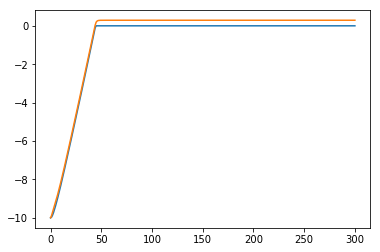

In [9]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.log.t,f.log.z)
x_hat = np.array(f.x_kalman)
ax.plot(f.t_kalman,-x_hat[:,1])

In [10]:
[f.Ve, f.v, -f.z]


[-2.5125993977468253e-05, 2.5125993977468564e-05, -0.0]

In [11]:
x0 = f.kalman.x_hat
gamma0 = f.kalman.gamma
print(x0)
print(gamma0)

[-1.79192877e-01 -2.89944614e-01  1.27534817e-05  0.00000000e+00]
[[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]


In [23]:
f.kalman.x_hat = x0
f.kalman.gamma = gamma0

(4,)


In [13]:
print(f.kalman.x_hat)
f.kalman.update_kalman(0., f.z, f.v)
print(f.kalman.x_hat)

[-1.79192877e-01 -2.89944614e-01  1.27534817e-05  0.00000000e+00]
x0 initial [-1.79192877e-01 -2.89944614e-01  1.27534817e-05  0.00000000e+00]
(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89960987e-01 1.23725195e-05]
x0 iteration [-1.79192879e-01 -2.89930493e-01  1.89397415e-05  0.00000000e+00]
x_hat [-1.79192879e-01 -2.89930493e-01  1.89397415e-05  0.00000000e+00]
u 0.0
z 0.0
v 2.5125993977468564e-05
gamma [[1.00998544e-04 1.13090809e-11 0.00000000e+00 0.00000000e+00]
 [1.13090809e-11 1.61803399e-06 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 5.12452248e-13 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 5.12452248e-15]]
[-1.79192879e-01 -2.89930493e-01  1.89397415e-05  0.00000000e+00]


In [14]:
y = f.kalman.gen_obs(f.z, f.v)
y

[-2.6080688066519848e-06, 2.5125981183682348e-05]

In [15]:
f.kalman.kalman_correc(x0,gamma0,y)

(2, 4) (2, 2) (4, 4)
K [[4.31968453e-06 0.00000000e+00]
 [6.18033989e-01 0.00000000e+00]
 [0.00000000e+00 5.00000000e-01]
 [0.00000000e+00 0.00000000e+00]]
ytilde [2.89942006e-01 1.23724994e-05]


(array([-1.79191624e-01, -1.10750600e-01,  1.89397315e-05,  0.00000000e+00]),
 array([[1.00998544e-04, 4.31968453e-12, 0.00000000e+00, 0.00000000e+00],
        [4.31968453e-12, 6.18033989e-07, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.56226124e-13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.12452248e-15]]))

In [16]:
f.kalman.gamma_beta

array([[1.00000000e-06, 0.00000000e+00],
       [0.00000000e+00, 5.12452248e-13]])

In [17]:
f.kalman.C@f.kalman.x_hat

array([-2.89930493e-01,  1.89397415e-05])

In [18]:
def kalman_correc(kalman, x0,gamma0,y):
    C = kalman.C
    S = C @ gamma0 @ C.T + kalman.gamma_beta
    K = gamma0 @ C.T @ np.linalg.inv(S)
    ytilde = np.array(y) - C @ x0
    Gup = (np.eye(len(x0))-K @ C) @ gamma0
    xup = x0 + K@ytilde
    return xup, Gup, ytilde, K

In [19]:
kalman_correc(f.kalman, x0,gamma0,y)

(array([-1.79191624e-01, -1.10750600e-01,  1.89397315e-05,  0.00000000e+00]),
 array([[1.00998544e-04, 4.31968453e-12, 0.00000000e+00, 0.00000000e+00],
        [4.31968453e-12, 6.18033989e-07, 0.00000000e+00, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 2.56226124e-13, 0.00000000e+00],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 5.12452248e-15]]),
 array([2.89942006e-01, 1.23724994e-05]),
 array([[4.31968453e-06, 0.00000000e+00],
        [6.18033989e-01, 0.00000000e+00],
        [0.00000000e+00, 5.00000000e-01],
        [0.00000000e+00, 0.00000000e+00]]))

(302, 4)


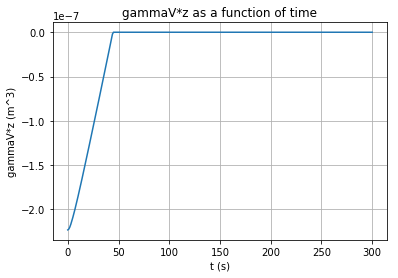

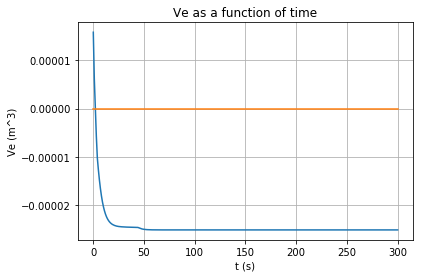

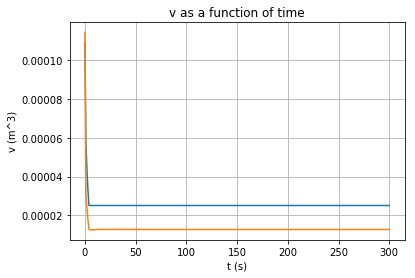

In [27]:
x_hat = np.array(f.x_kalman)

print(x_hat.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f.log.t, f.log.gammaV*f.log.z)
ax.set_title("gammaV*z as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("gammaV*z (m^3)")
ax.grid()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f.log.t, f.log.Ve)
ax.plot(f.t_kalman, x_hat[:,3])
ax.set_title("Ve as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("Ve (m^3)")
ax.grid()

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(f.log.t, f.log.v)
ax.plot(f.t_kalman,x_hat[:,2])
ax.set_title("v as a function of time")
ax.set_xlabel("t (s)")
ax.set_ylabel("v (m^3)")
ax.grid()

In [ ]:
fig = plt.figure()
ax=fig.add_subplot(111)
ax.plot(f.t_kalman,-x_hat[:,3])

In [ ]:
x_hat.shape

In [ ]:
# plot log
plot_log(f,z_target=z_target)

---

## Oscillations around a fixed level

In [ ]:
z_target = lambda t: -25+10.*np.sin(2.*np.pi/600.*t)

In [ ]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1.,
            usepiston=True, z_target=z_target, ctrl=control)

In [ ]:
plot_log(f,z_target=z_target)

---

## Maintains depth level around moving isopycnals

In [ ]:
eta = lambda t: 10.*np.sin(2.*np.pi/(60.*20.)*t)
z_target = lambda t: -25.+t*0.

In [ ]:
f.time_step(w,T=1800., dt_step=.1, dt_store=1., usepiston=True, z_target=z_target, ctrl=control, eta=eta)

In [ ]:
plot_log(f, z_target=z_target, eta=eta)

---

## Moving isopycnals without control

In [ ]:
iz = np.argmin(np.abs(z+25.))
v = f.volume4equilibrium(p[iz],temp[iz],rho_w[iz])
f.time_step(w, T=1800., dt_step=.1, dt_store=1., z=-25., w=0., v=v, usepiston=False, eta=eta)

In [ ]:
plot_log(f, z_target=z_target, eta=eta)